In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)


In [42]:
# pip install einops

In [50]:
import torch
import torch.nn as nn
from einops import rearrange

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

import math
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
class CBAM(nn.Module):
    def __init__(self,in_channel,reduction=16,kernel_size=7):
        super(CBAM, self).__init__()
        #通道注意力机制
        self.max_pool=nn.AdaptiveMaxPool2d(output_size=1)
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=1)
        self.mlp=nn.Sequential(
            nn.Linear(in_features=in_channel,out_features=in_channel//reduction,bias=False),
            nn.ReLU(),
            nn.Linear(in_features=in_channel//reduction,out_features=in_channel,bias=False)
        )
        self.sigmoid=nn.Sigmoid()
        #空间注意力机制
        self.conv=nn.Conv2d(in_channels=2,out_channels=1,kernel_size=kernel_size ,stride=1,padding=kernel_size//2,bias=False)

    def forward(self,x):
        #通道注意力机制
        maxout=self.max_pool(x)
        maxout=self.mlp(maxout.view(maxout.size(0),-1))
        avgout=self.avg_pool(x)
        avgout=self.mlp(avgout.view(avgout.size(0),-1))
        channel_out=self.sigmoid(maxout+avgout)
        channel_out=channel_out.view(x.size(0),x.size(1),1,1)
        channel_out=channel_out*x
        #空间注意力机制
        max_out,_=torch.max(channel_out,dim=1,keepdim=True)
        mean_out=torch.mean(channel_out,dim=1,keepdim=True)
        out=torch.cat((max_out,mean_out),dim=1)
        out=self.sigmoid(self.conv(out))
        out=out*channel_out
        return out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40)),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(p=0.2),
            nn.Conv2d(8, 16, kernel_size=(2, 3)),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Conv2d(16, 32, kernel_size=(2, 3)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        self.se=SELayer(32)
        self.ebam1 = CBAM(32)
        self.layer2 =nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(2, 2)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(64, 128, kernel_size=(1, 2)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(128,256,kernel_size=(1,2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(256, 256, kernel_size=(1, 2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            # nn.Conv2d(256, 512, kernel_size=(1, 2)),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(inplace=True),
            # nn.Dropout(p=0.2),  
            
            # nn.Conv2d(512, 512, kernel_size=(1, 2)),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(inplace=True),
            # nn.Dropout(p=0.2),  
        )
        # self.ebam2 = CBAM(256)
        # self.lstm = nn.LSTM(544, 544,num_layers=2, bidirectional=True, batch_first=True)
        # self.fc1 = nn.Linear(1088, 32)  # 修正为与LSTM输出相匹配
        self.lstm = nn.LSTM(320, 320,num_layers=2, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(640, 1)  # 修正为与LSTM输出相匹配
        # self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.2)  # 添加Dropout层

    def forward(self, x):
        try:
            #让模型先经过layers1，在分开去做ebam和layer2
            # print(x.shape)
            x = self.layers1(x)
            # print(x.shape)
            se_output = self.se(x)
            # print(se_output.shape)
            ebam_output = self.ebam1(x)
            # print(ebam_output.shape)
            layer2_output = self.layer2(x)
            # print(layer2_output.shape)
            cropped_ebam_output = ebam_output[:, :, :7, :15]
            cropped_se_output = se_output[:, :, :7, :15]
            x = torch.cat((layer2_output, cropped_ebam_output), dim=1)
            x =torch.cat((x,cropped_se_output),dim=1)
            x = to_3d(x)  # 转换为3D
            x, _ = self.lstm(x)  # LSTM处理
            x = x[:, -1, :]  # 取最后一个时序输出作为特征
            return torch.sigmoid(self.fc1(x))
        except RuntimeError as e:
            print(f"运行时错误：{e}")
            return None
        except Exception as e:
            print(f"发生意外错误：{e}")
            raise  # 重新抛出异常，以便进一步处理


In [56]:

net = Net()     # define the network
print(net)      # net architecture
# summary(net,(1,100,1000))

Net(
  (layers1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Dropout(p=0.2, inplace=False)
  )
  (se): SELayer(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=False)
      (

In [45]:
import pandas as pd
import torch.optim as optim
'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    



optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = torch.nn.MSELoss() 

# # 动态调整学习率
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.8 ** (epoch // 40))

# # 将学习率调度器修改为指数下降
# initial_lr = 0.0001  # 初始学习率
# decay_rate = 0.96  # 每个epoch衰减的比例
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: decay_rate ** epoch)

# 假设你已经定义了模型和优化器
# 当验证损失不下降时，减少学习率
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# 创建历史记录DataFrame
history = pd.DataFrame(columns=['index', 'train_loss', 'val_loss'])
val_losses = []
max_models_to_keep = 10
saved_models=[]
import os

for t in range(600):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    # 保存模型
    model_path = 'Target_model/net_parameters'+str(t)+'.pkl'
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, model_path)

    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print('Step = %d' % t, 'train_loss:', train_loss.data.numpy(), 'val_loss:', val_loss.data.numpy())
    val_losses.append(val_loss.item())
    
    # 添加当前模型及其验证损失
    saved_models.append((val_loss.item(), model_path))

    # 保持模型数量不超过max_models_to_keep
    if len(saved_models) > max_models_to_keep:
        # 找到验证损失最大的一组模型并删除
        saved_models.sort(key=lambda x: x[0])  # 排序，根据损失
        os.remove(saved_models.pop()[1])  # 删除损失最大的模型
    # 加入训练历史记录
    # 创建新的一行数据
    new_entry = pd.DataFrame({'index': [t], 'train_loss': [train_loss.item()], 'val_loss': [val_loss.item()]})
    
    # 使用concat进行数据合并
    history = pd.concat([history, new_entry], ignore_index=True)

'''find the best model'''
best_index = val_losses.index(np.min(val_losses))
print(f'Best model at index: {best_index}')

'''copy the best model from model file to the model_test file'''
shutil.copyfile(f'Target_model/net_parameters{best_index}.pkl', 'Best_target_model/net_parameters.pkl')

'''Reload the best model''' 
model = Net()
checkpoint = torch.load('Best_target_model/net_parameters.pkl')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


Step = 0 train_loss: 0.06578147 val_loss: 0.060390204


C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_34592\3624844004.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, new_entry], ignore_index=True)


Step = 1 train_loss: 0.06003259 val_loss: 0.059863992
Step = 2 train_loss: 0.055887196 val_loss: 0.059312906
Step = 3 train_loss: 0.05127959 val_loss: 0.05866853
Step = 4 train_loss: 0.047865245 val_loss: 0.057944912
Step = 5 train_loss: 0.04292569 val_loss: 0.05713389
Step = 6 train_loss: 0.040565614 val_loss: 0.056233864
Step = 7 train_loss: 0.03603587 val_loss: 0.055269316
Step = 8 train_loss: 0.034224946 val_loss: 0.05424957
Step = 9 train_loss: 0.03307597 val_loss: 0.053137727
Step = 10 train_loss: 0.02952212 val_loss: 0.051956687
Step = 11 train_loss: 0.02789092 val_loss: 0.05074015
Step = 12 train_loss: 0.029893579 val_loss: 0.0495646
Step = 13 train_loss: 0.030048244 val_loss: 0.048469033
Step = 14 train_loss: 0.02967746 val_loss: 0.04752022
Step = 15 train_loss: 0.03210314 val_loss: 0.04673549
Step = 16 train_loss: 0.031007556 val_loss: 0.046105854
Step = 17 train_loss: 0.028601239 val_loss: 0.045632396
Step = 18 train_loss: 0.03214031 val_loss: 0.04536188
Step = 19 train_loss

C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_34592\3624844004.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Best_target_model/net_parame

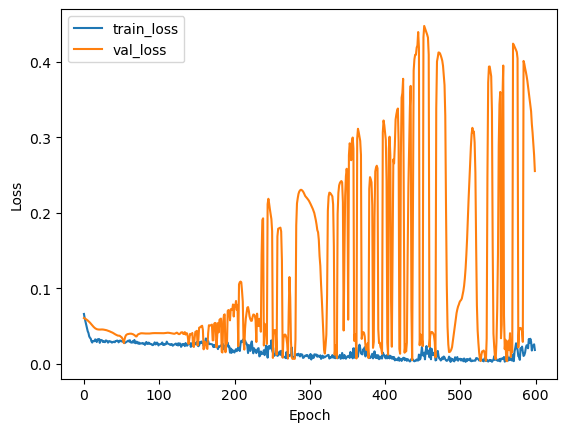

In [46]:
# history = np.DataFrame(columns=['index','train_loss', 'val_loss'])
#画出训练过程中的loss变化曲线
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:

'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)



mpe_train: 0.17390487
mpe_val: 0.18317622
mpe_a: 0.2274950758071332
mpe_b: 0.176973662397034
rmse_train: 114.98227
rmse_val: 126.08785
rmse_a: 149.43373735694732
rmse_b: 264.16192950536987


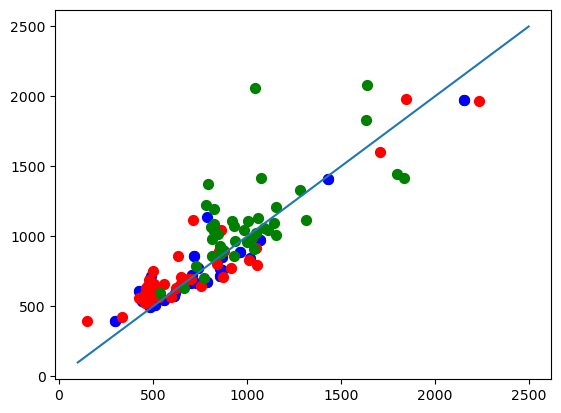

In [48]:

'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)

In [49]:
from sklearn.metrics import r2_score
r2_a = r2_score(actual_label_arr_a, predict_label_arr_a)
r2_b = r2_score(actual_label_arr_b, predict_label_arr_b)
r2_train = r2_score(actual_label_arr_train, predict_label_arr_train)
r2_val = r2_score(actual_label_arr_val, predict_label_arr_val)

print('r2_train:', r2_train)
print('r2_val:', r2_val)
print('r2_a:', r2_a)
print('r2_b:', r2_b)

r2_train: 0.9088449478149414
r2_val: 0.8472700715065002
r2_a: 0.8536774135429004
r2_b: 0.14155637990592906
